In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.image import ImageSeries
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA
import pdb

In [2]:
# ----- SET UP FILE HANDLING -----

computer = 'Ernest'
# computer = 'Dorian'

match computer:
    case 'Dorian':
        nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
        
    case 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

allnwb = []
# allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]

figp=os.path.join('figures','2024July') # where to save figures
saveplots=False

NameError: name 'assay' is not defined

In [3]:
nwbpath

'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

In [4]:
def consolidate_single_behavior_table(assay,behavior,nwbpath,printy):
    ''''''
    
    # collate all instances of behavior into a table
    # plot per individual cdf of time to behavior
    # normalize to total time doing that behavior
    # calculate as percent of assay time

    # make functions to generate table per assay x behavior

    FHet = 0
    MHet = 0
    FWT = 0
    MWT = 0
    
    allnwb = []
    allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]
    
    for i,fname in enumerate(allnwb):
                
        # open file
        io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
        nwbfile = io.read()

        # for sanity check, print out the name of the file being handled
        pathsplit = fname.split('\\')
        recstem = pathsplit[-1].strip('.nwb')
        if printy:
            print(recstem)
            
        try:
            data = nwbfile.intervals[f'single_behavior_{behavior}'].to_dataframe()
            nrentries = data.shape[0]

            # add metadata
            pair_tag = fname.split('\\')[-1].split('_')[1] # label the pair the observation came from    
            massGT = [nwbfile.subject.genotype]*nrentries
            massPairtag = [pair_tag]*nrentries
            massSex = [nwbfile.subject.sex]*nrentries
            massColors = [nwbfile.lab_meta_data['vole_metadata'].colors[:]]*nrentries
            if np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FHet]*nrentries
                FHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FWT]*nrentries
                FWT+=1
            elif np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='M'):
                massWithinGroup = [MHet]*nrentries
                MHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='M'):
                massWithinGroup = [MWT]*nrentries
                MWT+=1

            # add columns
            data['pair_tag'] = massPairtag
            data['sex'] = massSex
            data['GT'] = massGT
            data['pair'] = massWithinGroup
            data['color'] = massColors

            # consolidate into one big dataframe
            if i==0:
                rundf = data
            else:
                rundf = pd.concat([rundf,data])
            
        except:
            print(f'No {behavior}')
            
    rundf['raw_cumes'] = rundf.groupby('pair_tag').duration.cumsum()
    rundf['cumes_assay_frac'] = rundf.raw_cumes/1800
    rundf['totals'] = rundf.groupby('pair_tag')['duration'].transform('sum')
    rundf['cumes_behav_frac'] = rundf.raw_cumes/rundf.totals
            
    return rundf

In [9]:
def make_point_counts(assay,behavior,nwbpath,printy):
    df = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
    df['ones'] = [1]*df.shape[0]
    df['raw_cumes'] = df.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
    df['totals'] = df.groupby('pair_tag')['ones'].transform('sum')
    df['cumes_behav_frac'] = df.raw_cumes/df.totals
    return df

In [50]:
def consolidate_single_behavior_table_with_bins(assay,behavior,nwbpath,printy):
    ''''''
    
    # collate all instances of behavior into a table
    # plot per individual cdf of time to behavior
    # normalize to total time doing that behavior
    # calculate as percent of assay time

    # make functions to generate table per assay x behavior

    FHet = 0
    MHet = 0
    FWT = 0
    MWT = 0
    
    allnwb = []
    allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]
    
    for i,fname in enumerate(allnwb):
                
        # open file
        io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
        nwbfile = io.read()

        # for sanity check, print out the name of the file being handled
        pathsplit = fname.split('\\')
        recstem = pathsplit[-1].strip('.nwb')
        if printy:
            print(recstem)
            
        try:
            data = nwbfile.intervals[f'single_behavior_{behavior}'].to_dataframe()
            nrentries = data.shape[0]

            # add metadata
            pair_tag = fname.split('\\')[-1].split('_')[1] # label the pair the observation came from    
            massGT = [nwbfile.subject.genotype]*nrentries
            massPairtag = [pair_tag]*nrentries
            massSex = [nwbfile.subject.sex]*nrentries
            massColors = [nwbfile.lab_meta_data['vole_metadata'].colors[:]]*nrentries
            if np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FHet]*nrentries
                FHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FWT]*nrentries
                FWT+=1
            elif np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='M'):
                massWithinGroup = [MHet]*nrentries
                MHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='M'):
                massWithinGroup = [MWT]*nrentries
                MWT+=1

            # add columns
            data['pair_tag'] = massPairtag
            data['sex'] = massSex
            data['GT'] = massGT
            data['pair'] = massWithinGroup
            data['color'] = massColors

            # consolidate into one big dataframe
            if i==0:
                rundf = data
            else:
                rundf = pd.concat([rundf,data])
            
        except:
            print(f'No {behavior}')
            
    rundf['raw_cumes'] = rundf.groupby('pair_tag').duration.cumsum()
    rundf['cumes_assay_frac'] = rundf.raw_cumes/1800
    rundf['totals'] = rundf.groupby('pair_tag')['duration'].transform('sum')
    rundf['cumes_behav_frac'] = rundf.raw_cumes/rundf.totals
    
    allpairs = np.unique(rundf.pair_tag)

    for j,pair in enumerate(allpairs):
        nrbins = int(nrsteps)
        thisdf = rundf[rundf.pair_tag==pair]
        gt = np.unique(thisdf.GT)[0]
        sex = np.unique(thisdf.sex)[0]
        pn = np.unique(thisdf.pair)[0]
        thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
        thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
        startsl = thisdf.starts_idx.to_list()
        endsl = thisdf.ends_idx.to_list()
        blankbins = np.zeros((len(bins,)))
        for i,start in enumerate(startsl):
            blankbins[int(start):int(endsl[i])] = 1
        GTs = [gt]*nrsteps
        sexes = [sex]*nrsteps
        PTs = [pair]*nrsteps
        pairnr = [pn]*nrsteps
        bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair':pairnr}
        bindf = pd.DataFrame(data=bindat) 

        if j==0:
            runbins = bindf
        else:
            runbins = pd.concat([collbins,bindf])

    runbins['raw_cumes'] = runbins.groupby('pair_tag').data.cumsum()/10
    runbins['totals'] = runbins.groupby('pair_tag')['data'].transform('sum')/10
    runbins['cumes_behav_frac'] = runbins.raw_cumes/runbins.totals
            
    return rundf,runbins

In [63]:
# ----- ATTEMPTING TO FIX BINNING FUNCTION -----
def make_bins_from_DF(df):

    allpairs = np.unique(df.pair_tag)

    for j,pair in enumerate(allpairs):
        nrbins = int(nrsteps)
        thisdf = df[df.pair_tag==pair]
        gt = np.unique(thisdf.GT)[0]
        sex = np.unique(thisdf.sex)[0]
        pn = np.unique(thisdf.pair)[0]
        thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
        thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
        startsl = thisdf.starts_idx.to_list()
        endsl = thisdf.ends_idx.to_list()
        blankbins = np.zeros((len(bins,)))
        for i,start in enumerate(startsl):
            blankbins[int(start):int(endsl[i])] = 1
        GTs = [gt]*nrsteps
        sexes = [sex]*nrsteps
        PTs = [pair]*nrsteps
        pairnr = [pn]*nrsteps
        bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair':pairnr}
        bindf = pd.DataFrame(data=bindat) 

        if j==0:
            collbins = bindf
        else:
            collbins = pd.concat([collbins,bindf])

    collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
    collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
    collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals
        
    return collbins

In [48]:
# ----- PLOTTING FUNCTION FOR CDFS -----

def make_cumulative_binned_plots(rundf,sex,behavior,assay):
    ''''''
    nrows=1
    ncols=2

    if sex=='M':
        usepal = mpal
    else:
        usepal = fpal

    # make figure and subplots
    f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
    f.tight_layout()

    ax0 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="raw_cumes", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[0],
    )
    ax0.set_xlabel('assay time (s)')
    ax0.set_ylabel('total time (s)')


    ax1 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="cumes_behav_frac", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[1],
    )
    ax1.set_xlabel('assay time (s)')
    ax1.set_ylabel(f'fraction {behavior} time')

    f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)

In [6]:
# ----- PLOTTING FUNCTION FOR CDFS -----

def make_cumulative_time_plots(rundf,sex,behavior,assay):
    ''''''
    nrows=1
    ncols=2

    if sex=='M':
        usepal = mpal
    else:
        usepal = fpal

    # make figure and subplots
    f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
    f.tight_layout()

    ax0 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="start_time", y="raw_cumes", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[0],
    )
    ax0.set_xlabel('assay time (s)')
    ax0.set_ylabel('total time (s)')


    ax1 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="start_time", y="cumes_behav_frac", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[1],
    )
    ax1.set_xlabel('assay time (s)')
    ax1.set_ylabel(f'fraction {behavior} time')

    f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)

In [10]:
def single_behavior_cdf_collate_data_and_plot(assay,behavior,printy):
    df = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
    make_cumulative_time_plots(df,'M',behavior,assay)
    make_cumulative_time_plots(df,'F',behavior,assay)
    return df

In [54]:
def single_behavior_binned_collate_data_and_plot(assay,behavior,printy):
    (rawdf,bindf) = consolidate_single_behavior_table_with_bins(assay,behavior,nwbpath,printy)
    make_cumulative_binned_plots(bindf,'M',behavior,assay)
    make_cumulative_binned_plots(bindf,'F',behavior,assay)
    return bindf

In [7]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

In [6]:
# collate all instances of behavior into a table
# plot per individual cdf of time to behavior
# normalize to total time doing that behavior
# calculate as percent of assay time

# make functions to generate table per assay x behavior

FHet = 0
MHet = 0
FWT = 0
MWT = 0

for i,fname in enumerate(allnwb):
    # open file
    io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
    nwbfile = io.read()
    
    # for sanity check, print out the name of the file being handled
    pathsplit = fname.split('\\')
    recstem = pathsplit[-1].strip('.nwb')
    print(recstem)

    data = nwbfile.intervals[f'single_behavior_{behavior}'].to_dataframe()
    nrentries = data.shape[0]
    
    # add metadata
    pair_tag = fname.split('\\')[-1].split('_')[1] # label the pair the observation came from    
    massGT = [nwbfile.subject.genotype]*nrentries
    massPairtag = [pair_tag]*nrentries
    massSex = [nwbfile.subject.sex]*nrentries
    massColors = [nwbfile.lab_meta_data['vole_metadata'].colors[:]]*nrentries
    if np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='F'): 
        massWithinGroup = [FHet]*nrentries
        FHet+=1
    elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='F'): 
        massWithinGroup = [FWT]*nrentries
        FWT+=1
    elif np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='M'):
        massWithinGroup = [MHet]*nrentries
        MHet+=1
    elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='M'):
        massWithinGroup = [MWT]*nrentries
        MWT+=1

    # add columns
    data['pair_tag'] = massPairtag
    data['sex'] = massSex
    data['GT'] = massGT
    data['pair'] = massWithinGroup
    data['color'] = massColors
    
    # consolidate into one big dataframe
    if i==0:
        rundf = data
    else:
        rundf = pd.concat([rundf,data])
        


Nov22_Pair15_introductio
Nov22_Pair16_introductio
Nov22_Pair17_introductio
Nov22_Pair18_introductio
Nov22_Pair19_introductio
Nov22_Pair1_introductio
Nov22_Pair21_introductio
Nov22_Pair22_introductio
Nov22_Pair23_introductio
Nov22_Pair24_introductio
Nov22_Pair25_introductio
Nov22_Pair26_introductio
Nov22_Pair27_introductio
Nov22_Pair28_introductio
Nov22_Pair29_introductio
Nov22_Pair2_introductio
Nov22_Pair30_introductio
Nov22_Pair31_introductio
Nov22_Pair32_introductio
Nov22_Pair33_introductio
Nov22_Pair34_introductio
Nov22_Pair35_introductio
Nov22_Pair36_introductio
Nov22_Pair37_introductio
Nov22_Pair38_introductio
Nov22_Pair39_introductio
Nov22_Pair3_introductio
Nov22_Pair40_introductio
Nov22_Pair41_introductio
Nov22_Pair42_introductio
Nov22_Pair43_introductio
Nov22_Pair44_introductio
Nov22_Pair46_introductio
Nov22_Pair47_introductio
Nov22_Pair48_introductio
Nov22_Pair49_introductio
Nov22_Pair4_introductio
Nov22_Pair50_introductio
Nov22_Pair51_introductio
Nov22_Pair52_introductio
Nov2

In [12]:
rundf.head()

,start_time,stop_time,behavior,duration,atype,pair_tag,sex,GT,pair,color,raw_cumes
id,,,,,,,,,,,
4,45.483,49.233,Sniff,3.750,STATE,Pair15,F,Het,0,"[245.0, 201.0, 39.0]",3.750
30,248.983,250.483,Sniff,1.500,STATE,Pair15,F,Het,0,"[245.0, 201.0, 39.0]",5.250
32,250.981,252.233,Sniff,1.252,STATE,Pair15,F,Het,0,"[245.0, 201.0, 39.0]",6.502
34,252.734,257.233,Sniff,4.499,STATE,Pair15,F,Het,0,"[245.0, 201.0, 39.0]",11.001
36,258.734,259.029,Sniff,0.295,STATE,Pair15,F,Het,0,"[245.0, 201.0, 39.0]",11.296


In [23]:
# ----- ADD CUMULATIVE TIMES TO DATAFRAME -----
rundf['raw_cumes'] = rundf.groupby('pair_tag').duration.cumsum()
rundf['cumes_assay_frac'] = rundf.raw_cumes/1800
rundf['totals'] = rundf.groupby('pair_tag')['duration'].transform('sum')
rundf['cumes_behav_frac'] = rundf.raw_cumes/rundf.totals

Text(0.5, 1.02, 'Cumulative Sniff in introduction')

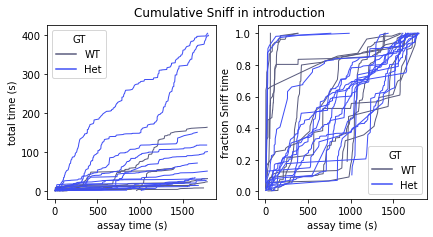

In [39]:
# ----- PLOT MALES -----

nrows=1
ncols=2
sex = 'M'

# make figure and subplots
f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
f.tight_layout()

ax0 = sns.lineplot(
    data=rundf[rundf.sex==sex],
    x="start_time", y="raw_cumes", hue="GT", units="pair",
    estimator=None, lw=1,palette=mpal,hue_order=ho,
    ax=ax[0],
)
ax0.set_xlabel('assay time (s)')
ax0.set_ylabel('total time (s)')


ax1 = sns.lineplot(
    data=rundf[rundf.sex=='M'],
    x="start_time", y="cumes_behav_frac", hue="GT", units="pair",
    estimator=None, lw=1,palette=mpal,hue_order=ho,
    ax=ax[1],
)
ax1.set_xlabel('assay time (s)')
ax1.set_ylabel(f'fraction {behavior} time')

f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)

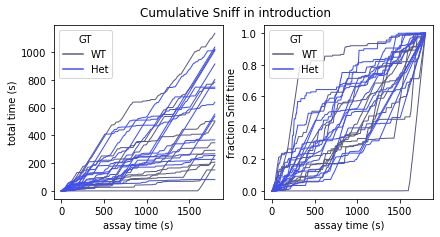

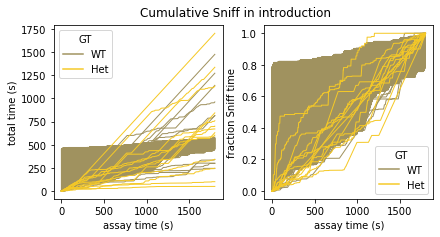

In [59]:
# ----- INTRODUCTION SNIFFS -----
assay = 'introduction'
behavior = 'Sniff'
printy = False
IntSniffBins = single_behavior_binned_collate_data_and_plot(assay,behavior,printy)

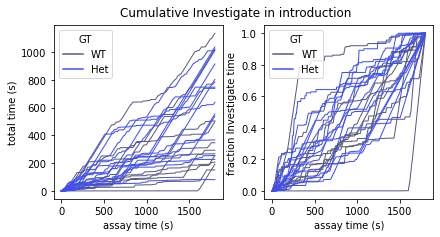

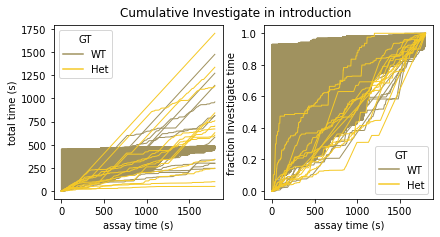

In [60]:
import warnings
warnings.filterwarnings('ignore')

# ----- INTRODUCTION INVESTIGATE -----
assay = 'introduction'
behavior = 'Investigate'
printy = False
IntInvBins = single_behavior_binned_collate_data_and_plot(assay,behavior,printy)

In [58]:
IntSniffBins[IntSniffBins.sex=='M'].shape

(468000, 9)

Text(0.5, 1.02, 'Cumulative Investigate in introduction')

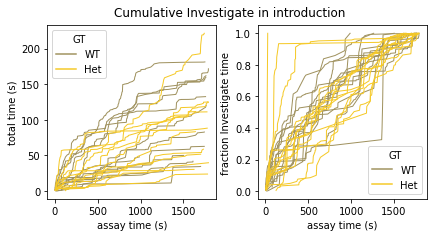

In [166]:
# ----- PLOT FEMALES -----

nrows=1
ncols=2
sex = 'F'

if sex=='M':
    usepal = mpal
else:
    usepal = fpal

# make figure and subplots
f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
f.tight_layout()

ax0 = sns.lineplot(
    data=rundf[rundf.sex==sex],
    x="start_time", y="raw_cumes", hue="GT", units="pair_tag",
    estimator=None, lw=1,palette=usepal,hue_order=ho,
    ax=ax[0],
)
ax0.set_xlabel('assay time (s)')
ax0.set_ylabel('total time (s)')


ax1 = sns.lineplot(
    data=rundf[rundf.sex==sex],
    x="start_time", y="cumes_behav_frac", hue="GT", units="pair_tag",
    estimator=None, lw=1,palette=usepal,hue_order=ho,
    ax=ax[1],
)
ax1.set_xlabel('assay time (s)')
ax1.set_ylabel(f'fraction {behavior} time')

f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)

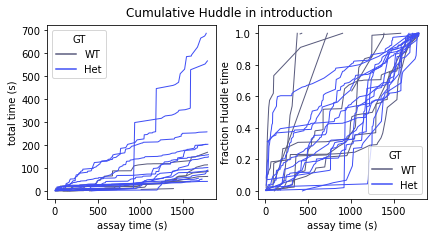

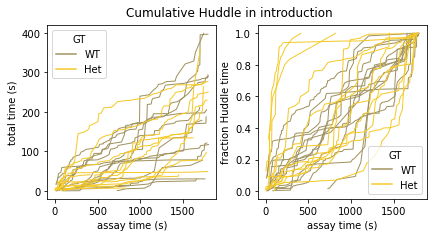

In [63]:
# ----- HUDDLE INTROS -----
assay = 'introduction'
behavior = 'Huddle'
printy = True
# InHudDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
# InHudDF['raw_cumes'] = InHudDF.groupby('pair_tag').duration.cumsum()
# InHudDF['cumes_assay_frac'] = InHudDF.raw_cumes/1800
# InHudDF['totals'] = InHudDF.groupby('pair_tag')['duration'].transform('sum')
# InHudDF['cumes_behav_frac'] = InHudDF.raw_cumes/InHudDF.totals
make_cumulative_time_plots(InHudDF,'M',behavior,assay)
make_cumulative_time_plots(InHudDF,'F',behavior,assay)

In [64]:
# ----- TEST BINNING -----
InHudBins = make_bins_from_DF(InHudDF)
make_cumulative_binned_plots(InHudBins,'M','Huddle','Introduction')
make_cumulative_binned_plots(InHudBins,'F','Huddle','Introduction')

NameError: name 'InHudDF' is not defined

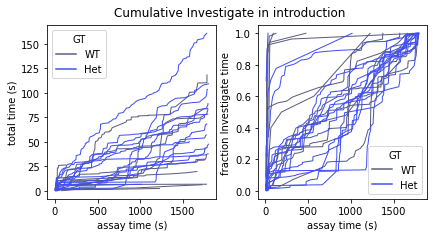

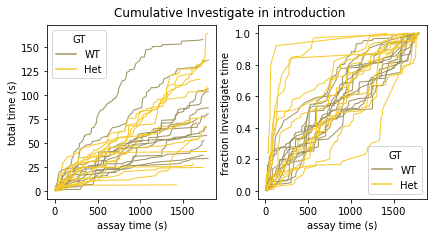

In [67]:
# ----- INTRODUCTION INVESTIGATE -----
assay = 'introduction'
behavior = 'Investigate'
printy = True
# InInvDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
# InInvDF['raw_cumes'] = InInvDF.groupby('pair_tag').duration.cumsum()
# InInvDF['cumes_assay_frac'] = InInvDF.raw_cumes/1800
# InInvDF['totals'] = InInvDF.groupby('pair_tag')['duration'].transform('sum')
# InInvDF['cumes_behav_frac'] = InInvDF.raw_cumes/InInvDF.totals
make_cumulative_time_plots(InInvDF,'M',behavior,assay)
make_cumulative_time_plots(InInvDF,'F',behavior,assay)

In [95]:
prosoc = pd.concat([rundf,InInvDF,InHudDF])
prosoc.pop('raw_cumes')
prosoc.pop('cumes_assay_frac')
prosoc.pop('totals')
prosoc.pop('cumes_behav_frac')
prosoc.pop('behavior')
prosoc.pop('stop_time')
prosoc.pop('atype')
prosoc = prosoc.sort_values(by=['pair_tag','start_time'])
prosoc['raw_cumes'] = prosoc.groupby('pair_tag').duration.cumsum()
prosoc['cumes_assay_frac'] = prosoc.raw_cumes/1800
prosoc['totals'] = prosoc.groupby('pair_tag')['duration'].transform('sum')
prosoc['cumes_behav_frac'] = prosoc.raw_cumes/prosoc.totals

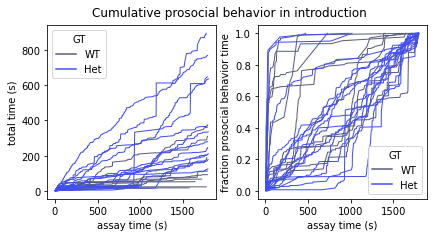

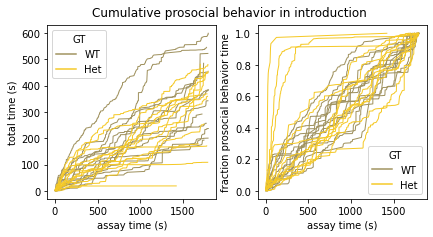

In [169]:
make_cumulative_time_plots(prosoc,'M','prosocial behavior',assay)
make_cumulative_time_plots(prosoc,'F','prosocial behavior',assay)

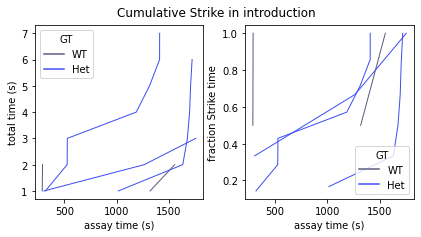

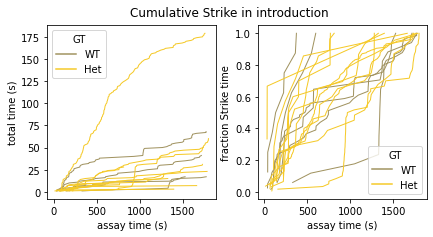

In [33]:
# ----- DO AGONISTIC BEHAVIOR POINT EVENTS -----

# ----- STRIKE INTROS -----
assay = 'introduction'
behavior = 'Strike'
printy = True
# InStrikeDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
InStrikeDF['ones'] = [1]*InStrikeDF.shape[0]
InStrikeDF['raw_cumes'] = InStrikeDF.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
InStrikeDF['totals'] = InStrikeDF.groupby('pair_tag')['ones'].transform('sum')
InStrikeDF['cumes_behav_frac'] = InStrikeDF.raw_cumes/InStrikeDF.totals
make_cumulative_time_plots(InStrikeDF,'M',behavior,assay)
make_cumulative_time_plots(InStrikeDF,'F',behavior,assay)

In [10]:
# ----- AGGRESSION POINT EVENTS -----
assay = 'aggression'
behaviors = ['Tussle','Strike','Defensive strike']
printy=True
for i,behavior in enumerate(behaviors):
    thisdf = make_point_counts(assay,behavior,nwbpath,printy)
    
    if i==0:
        antisoc = thisdf
    else:
        antisoc = pd.concat([antisoc,thisdf])



Nov22_Pair15_aggressio
Nov22_Pair16_aggressio
Nov22_Pair17_aggressio
Nov22_Pair18_aggressio
Nov22_Pair19_aggressio
Nov22_Pair1_aggressio
Nov22_Pair21_aggressio
Nov22_Pair22_aggressio
No Tussle
Nov22_Pair23_aggressio
No Tussle
Nov22_Pair24_aggressio
No Tussle
Nov22_Pair25_aggressio
No Tussle
Nov22_Pair26_aggressio
Nov22_Pair27_aggressio
No Tussle
Nov22_Pair28_aggressio
No Tussle
Nov22_Pair29_aggressio
No Tussle
Nov22_Pair2_aggressio
Nov22_Pair30_aggressio
No Tussle
Nov22_Pair31_aggressio
Nov22_Pair32_aggressio
No Tussle
Nov22_Pair33_aggressio
No Tussle
Nov22_Pair34_aggressio
Nov22_Pair35_aggressio
Nov22_Pair36_aggressio
Nov22_Pair37_aggressio
No Tussle
Nov22_Pair38_aggressio
Nov22_Pair39_aggressio
Nov22_Pair3_aggressio
Nov22_Pair40_aggressio
No Tussle
Nov22_Pair41_aggressio
Nov22_Pair43_aggressio
No Tussle
Nov22_Pair44_aggressio
Nov22_Pair46_aggressio
Nov22_Pair47_aggressio
No Tussle
Nov22_Pair48_aggressio
No Tussle
Nov22_Pair49_aggressio
Nov22_Pair4_aggressio
No Tussle
Nov22_Pair50_agg

In [11]:
antisoc.pop('raw_cumes')
antisoc.pop('cumes_assay_frac')
antisoc.pop('totals')
antisoc.pop('cumes_behav_frac')
antisoc.pop('behavior')
antisoc.pop('stop_time')
antisoc.pop('atype')
antisoc = antisoc.sort_values(by=['pair_tag','start_time'])
antisoc['ones'] = [1]*antisoc.shape[0]
antisoc['raw_cumes'] = antisoc.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
antisoc['totals'] = antisoc.groupby('pair_tag')['ones'].transform('sum')
antisoc['cumes_behav_frac'] = antisoc.raw_cumes/antisoc.totals

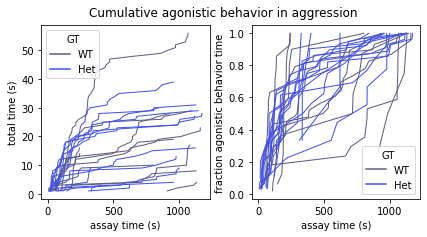

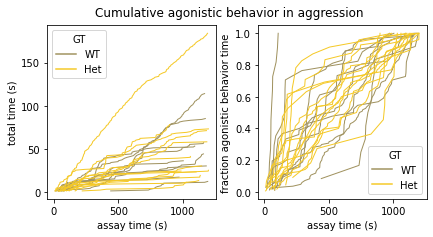

In [13]:
make_cumulative_time_plots(antisoc,'M','agonistic behavior',assay)
make_cumulative_time_plots(antisoc,'F','agonistic behavior',assay)

Nov22_Pair15_introductio
Nov22_Pair16_introductio
No Tussle
Nov22_Pair17_introductio
No Tussle
Nov22_Pair18_introductio
No Tussle
Nov22_Pair19_introductio
No Tussle
Nov22_Pair1_introductio
No Tussle
Nov22_Pair21_introductio
No Tussle
Nov22_Pair22_introductio
No Tussle
Nov22_Pair23_introductio
Nov22_Pair24_introductio
Nov22_Pair25_introductio
No Tussle
Nov22_Pair26_introductio
No Tussle
Nov22_Pair27_introductio
No Tussle
Nov22_Pair28_introductio
No Tussle
Nov22_Pair29_introductio
No Tussle
Nov22_Pair2_introductio
Nov22_Pair30_introductio
Nov22_Pair31_introductio
No Tussle
Nov22_Pair32_introductio
No Tussle
Nov22_Pair33_introductio
No Tussle
Nov22_Pair34_introductio
No Tussle
Nov22_Pair35_introductio
No Tussle
Nov22_Pair36_introductio
No Tussle
Nov22_Pair37_introductio
No Tussle
Nov22_Pair38_introductio
Nov22_Pair39_introductio
Nov22_Pair3_introductio
Nov22_Pair40_introductio
No Tussle
Nov22_Pair41_introductio
No Tussle
Nov22_Pair42_introductio
Nov22_Pair43_introductio
No Tussle
Nov22_Pa

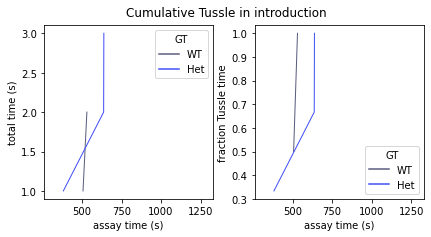

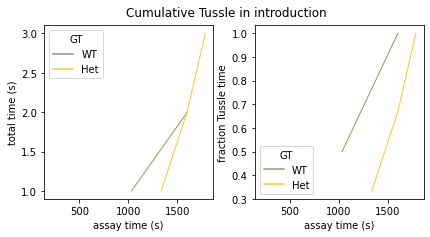

In [35]:
# -----  INTROS -----
assay = 'introduction'
behavior = 'Tussle'
printy = True
InTussleDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
InTussleDF['ones'] = [1]*InTussleDF.shape[0]
InTussleDF['raw_cumes'] = InTussleDF.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
InTussleDF['totals'] = InTussleDF.groupby('pair_tag')['ones'].transform('sum')
InTussleDF['cumes_behav_frac'] = InTussleDF.raw_cumes/InTussleDF.totals
make_cumulative_time_plots(InTussleDF,'M',behavior,assay)
make_cumulative_time_plots(InTussleDF,'F',behavior,assay)

Nov22_Pair15_introductio
Nov22_Pair16_introductio
Nov22_Pair17_introductio
Nov22_Pair18_introductio
Nov22_Pair19_introductio
Nov22_Pair1_introductio
Nov22_Pair21_introductio
Nov22_Pair22_introductio
Nov22_Pair23_introductio
Nov22_Pair24_introductio
Nov22_Pair25_introductio
No Defensive strike
Nov22_Pair26_introductio
Nov22_Pair27_introductio
No Defensive strike
Nov22_Pair28_introductio
Nov22_Pair29_introductio
Nov22_Pair2_introductio
No Defensive strike
Nov22_Pair30_introductio
Nov22_Pair31_introductio
Nov22_Pair32_introductio
No Defensive strike
Nov22_Pair33_introductio
Nov22_Pair34_introductio
Nov22_Pair35_introductio
Nov22_Pair36_introductio
Nov22_Pair37_introductio
Nov22_Pair38_introductio
Nov22_Pair39_introductio
Nov22_Pair3_introductio
Nov22_Pair40_introductio
Nov22_Pair41_introductio
Nov22_Pair42_introductio
Nov22_Pair43_introductio
No Defensive strike
Nov22_Pair44_introductio
Nov22_Pair46_introductio
Nov22_Pair47_introductio
No Defensive strike
Nov22_Pair48_introductio
No Defen

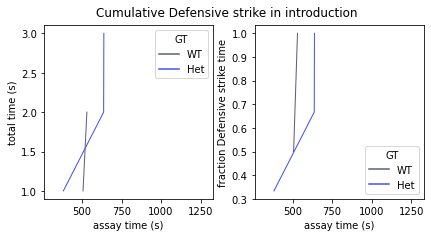

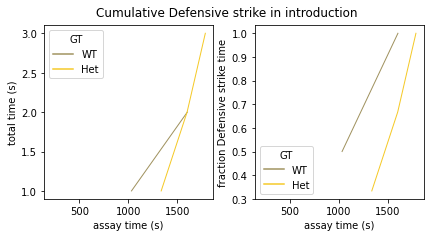

In [36]:
# -----  INTROS -----
assay = 'introduction'
behavior = 'Defensive strike'
printy = True
InDefDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
InDefDF['ones'] = [1]*InDefDF.shape[0]
InDefDF['raw_cumes'] = InDefDF.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
InDefDF['totals'] = InDefDF.groupby('pair_tag')['ones'].transform('sum')
InDefDF['cumes_behav_frac'] = InDefDF.raw_cumes/InDefDF.totals
make_cumulative_time_plots(InTussleDF,'M',behavior,assay)
make_cumulative_time_plots(InTussleDF,'F',behavior,assay)

In [38]:
antisoc = pd.concat([InStrikeDF,InTussleDF,InDefDF])
antisoc.pop('raw_cumes')
antisoc.pop('cumes_assay_frac')
antisoc.pop('totals')
antisoc.pop('cumes_behav_frac')
antisoc.pop('behavior')
antisoc.pop('stop_time')
antisoc.pop('atype')
antisoc = antisoc.sort_values(by=['pair_tag','start_time'])
antisoc['ones'] = [1]*antisoc.shape[0]
antisoc['raw_cumes'] = antisoc.groupby('pair_tag').ones.cumsum()# use numpy argsort on start_times
antisoc['totals'] = antisoc.groupby('pair_tag')['ones'].transform('sum')
antisoc['cumes_behav_frac'] = antisoc.raw_cumes/antisoc.totals

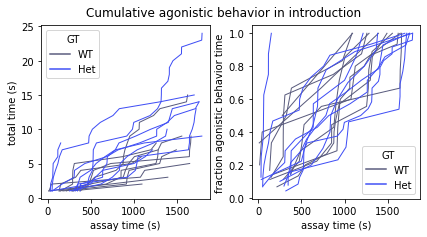

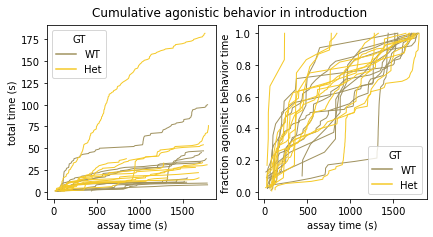

In [40]:
make_cumulative_time_plots(antisoc,'M','agonistic behavior',assay)
make_cumulative_time_plots(antisoc,'F','agonistic behavior',assay)

Nov22_Pair15_reunio
Nov22_Pair16_reunio
Nov22_Pair17_reunio
Nov22_Pair18_reunio
Nov22_Pair19_reunio
Nov22_Pair1_reunio
Nov22_Pair21_reunio
Nov22_Pair22_reunio
Nov22_Pair23_reunio
Nov22_Pair24_reunio
Nov22_Pair25_reunio
Nov22_Pair26_reunio
Nov22_Pair27_reunio
Nov22_Pair28_reunio
Nov22_Pair29_reunio
Nov22_Pair2_reunio
Nov22_Pair30_reunio
Nov22_Pair31_reunio
Nov22_Pair32_reunio
Nov22_Pair33_reunio
Nov22_Pair34_reunio
Nov22_Pair35_reunio
Nov22_Pair36_reunio
Nov22_Pair37_reunio
Nov22_Pair38_reunio
Nov22_Pair39_reunio
Nov22_Pair3_reunio
Nov22_Pair40_reunio
Nov22_Pair41_reunio
Nov22_Pair43_reunio
Nov22_Pair44_reunio
Nov22_Pair46_reunio
Nov22_Pair47_reunio
Nov22_Pair48_reunio
Nov22_Pair49_reunio
Nov22_Pair4_reunio
Nov22_Pair50_reunio
Nov22_Pair51_reunio
Nov22_Pair52_reunio
Nov22_Pair56_reunio
Nov22_Pair57_reunio
Nov22_Pair58_reunio
Nov22_Pair59_reunio
Nov22_Pair5_reunio
Nov22_Pair60_reunio
Nov22_Pair61_reunio
Nov22_Pair62_reunio
Nov22_Pair64_reunio
Nov22_Pair6_reunio
Nov22_Pair7_reunio
Nov22_P

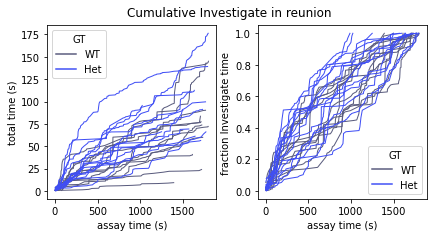

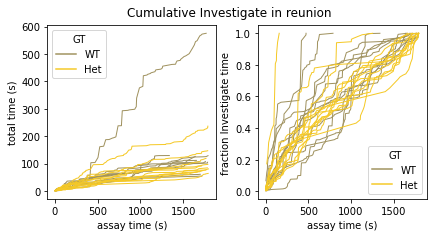

In [7]:
# ----- REUNIFICATION INVESTIGATE -----
assay = 'reunion'
behavior = 'Investigate'
printy = True
ReInvDF = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
make_cumulative_time_plots(ReInvDF,'M',behavior,assay)
make_cumulative_time_plots(ReInvDF,'F',behavior,assay)

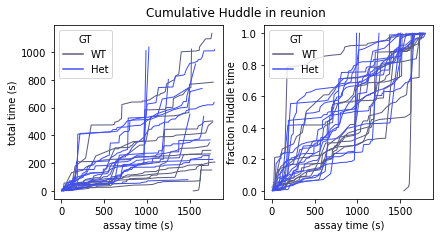

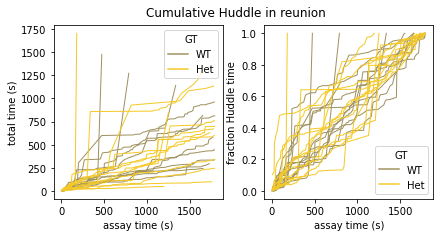

In [11]:
# ----- REUNIFICATION HUDDLE -----
assay = 'reunion'
behavior = 'Huddle'
printy = False
ReHudDF = single_behavior_cdf_collate_data_and_plot(assay,behavior,printy)

In [ ]:
# at each time bin, how much time has been spent in a huddle thus far
# sum durations from end times before current bins
# sum start to end of bin for events spanning the bin

In [21]:
# bins = list(range(0,1800, 60))
bins = np.linspace
test = ReHudDF.groupby(['pair_tag', pd.cut(ReHudDF.start_time, bins)]) \
    .agg({'duration': 'sum'}) \
        .groupby('pair_tag') \
        .cumsum() \
        .reset_index()

TypeError: 'float' object cannot be interpreted as an integer

In [19]:
test

,pair_tag,start_time,duration
0,Pair1,"(0, 60]",33.314
1,Pair1,"(60, 120]",76.313
2,Pair1,"(120, 180]",99.812
3,Pair1,"(180, 240]",123.309
4,Pair1,"(240, 300]",152.495
...,...,...,...
1474,Pair8,"(1440, 1500]",406.482
1475,Pair8,"(1500, 1560]",410.231
1476,Pair8,"(1560, 1620]",411.730
1477,Pair8,"(1620, 1680]",428.468


In [35]:
# make a binary mask by second binning
stepsize = 0.1
maxval = 1800
minval = 0
nrsteps = int((maxval-minval)/stepsize)
bins = np.linspace(0, 1800-stepsize, num=int(nrsteps))

In [23]:
nrsteps

18000.0

In [41]:
allpairs = np.unique(ReHudDF.pair_tag)

for j,pair in enumerate(allpairs):
    nrbins = int(nrsteps)
    thisdf = ReHudDF[ReHudDF.pair_tag==pair]
    gt = np.unique(thisdf.GT)[0]
    sex = np.unique(thisdf.sex)[0]
    pn = np.unique(thisdf.pair)[0]
    thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
    thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
    startsl = thisdf.starts_idx.to_list()
    endsl = thisdf.ends_idx.to_list()
    blankbins = np.zeros((len(bins,)))
    for i,start in enumerate(startsl):
        blankbins[int(start):int(endsl[i])] = 1
    GTs = [gt]*nrsteps
    sexes = [sex]*nrsteps
    PTs = [pair]*nrsteps
    pairnr = [pn]*nrsteps
    bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair':pairnr}
    bindf = pd.DataFrame(data=bindat) 
    
    if j==0:
        collbins = bindf
    else:
        collbins = pd.concat([collbins,bindf])
        
collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals
        
    

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
C:\Users\Nerissa\AppData\Local\Temp\ipykernel_22576\1904507593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [46]:
collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals

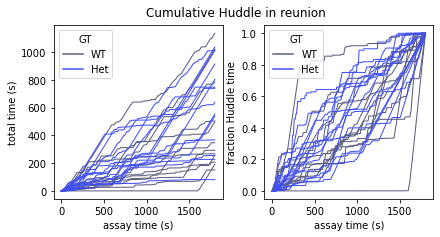

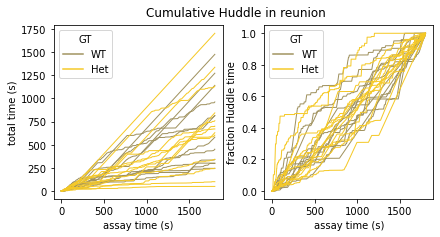

In [49]:
make_cumulative_binned_plots(collbins,'M',behavior,assay)
make_cumulative_binned_plots(collbins,'F',behavior,assay)

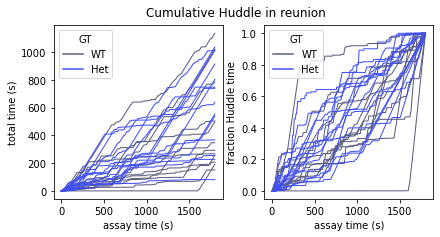

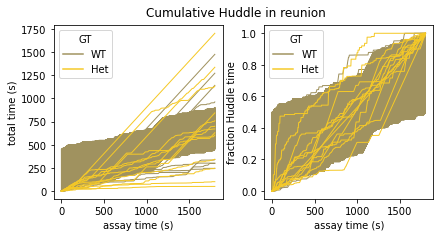

In [61]:
# ----- TEST REUNION HUDDLE -----
assay = 'reunion'
behavior = 'Huddle'
printy = False
ReuHudBins = single_behavior_binned_collate_data_and_plot(assay,behavior,printy)

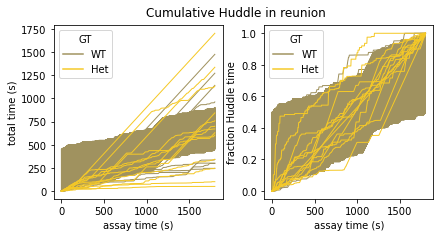

In [62]:
make_cumulative_binned_plots(ReuHudBins,'F',behavior,assay)

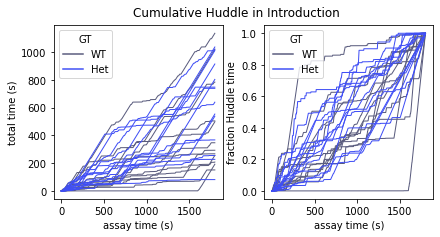

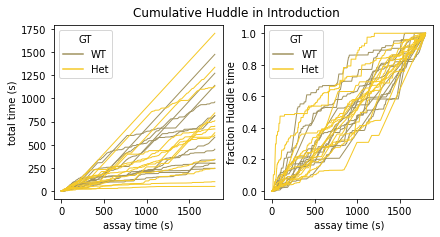

In [65]:
# ----- TEST BINNING -----
ReHudBins = make_bins_from_DF(ReHudDF)
make_cumulative_binned_plots(ReHudBins,'M','Huddle','Introduction')
make_cumulative_binned_plots(ReHudBins,'F','Huddle','Introduction')

In [66]:
nrsteps

18000